In [1]:
%load_ext autoreload
%autoreload 2
import json
import os
import sys

import keras.backend as K
from keras.models import load_model
from keras.optimizers import Adam
import numpy as np
import tensorflow as tf

from dataset_utils import adni_loader
#from networks import transform_network_utils

sys.path.append('../neuron')
sys.path.append('../voxelmorph')
import src.networks as vm_networks

sys.path.append('../voxelmorph-sandbox/')
from voxelmorph.dense_3D_spatial_transformer import Dense3DSpatialTransformer



gpu_ids = [2]
# set gpu id and tf settings
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(g) for g in gpu_ids])
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))



start_iter = 0
voxelmorph_model_old = load_model(
    #'/afs/csail.mit.edu/u/x/xamyzhao/voxelmorph/models/vm2_cc.h5',
    './experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_iter100000.h5',#.format(start_iter),
    custom_objects={'Dense3DSpatialTransformer': Dense3DSpatialTransformer},
    compile=False,
)

# # reset weights to random
# from keras.initializers import glorot_uniform
# session = K.get_session()
# initial_weights = voxelmorph_model.get_weights()
# new_weights = [glorot_uniform()(w.shape).eval(session=session) for w in initial_weights]
# voxelmorph_model.set_weights(new_weights)


Using TensorFlow backend.
../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


Load training dataset

In [2]:
dataset_key = 'adni-3d-100-unnorm-masked'
import vte_runner
data_params = vte_runner.named_vte_data_params[dataset_key]
    
ds = adni_loader.ADNIDataset(data_params)

vol_shape = tuple(data_params['img_shape'])

# just load some examples so we can get the image size, but actually use a generator later...
(X_unlabeled, _, ids_unlabeled),\
(X_labeled_train, Y_labeled_train, ids_labeled_train), \
(X_labeled_valid, Y_labeled_valid, ids_labeled_valid), \
label_mapping \
= ds.load_dataset(debug=False)

../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


Loading adni dataset adni-unnorm-masked_100ul_atlas-l
Params: {'dataset_name': 'adni', 'source_name': 'atl', 'target_name': 'subjs', 'masked': True, 'n_shot': 1, 'use_atlas_as_source': True, 'img_shape': (160, 192, 224, 1), 'pred_img_shape': (160, 192, 1), 'aug_img_shape': (160, 192, 224, 1), 'n_unlabeled': 100, 'n_validation': 50, 'load_vols': True, 'aug_in_gen': True, 'n_flow_aug': None, 'n_vte_aug': None, 'unnormalized': True, 'use_labels': [0, 16, 10, 49, 8, 47, 4, 43, 7, 46, 12, 51, 2, 41, 28, 60, 11, 50, 13, 52, 17, 53, 14, 15, 18, 54, 24, 3, 42, 31, 63], 'final_test': False, 'n_dims': 3, 'orig_img_shape': (160, 192, 224, 1), 'scale': 1.0, 'split_id': None}
Got list of 7329 files from /data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/*.npz:
ADNI_ADNI-3T-FS-5.3-Long_293689.long.016_S_4591_base_mri_talairach_orig.npz
ADNI_ADNI-3T-FS-5.3-Long_78841.long.016_S_1326_base_mri_talairach_orig.npz
ADNI_ADNI-1.5T-FS-5.3-Long_436815.long.094_S_1330_base_mri_talairach_ori

(101, 160, 192, 224, 1)
(1, 160, 192, 224, 1)
(50, 160, 192, 224, 1)
['atlas']
True


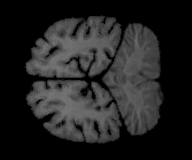

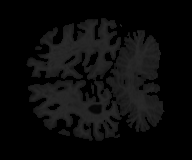

In [3]:
print(X_unlabeled.shape)
print(X_labeled_train.shape)
print(X_labeled_valid.shape)
print(ds.files_labeled_train)
print(ds.params['load_vols'])
import IPython
import PIL
IPython.display.display(PIL.Image.fromarray((X_labeled_train[0, :, :, 64, 0]*255).astype(np.uint8)))
IPython.display.display(PIL.Image.fromarray((X_unlabeled[0, :, :, 64, 0]*255).astype(np.uint8)))


[(None, 160, 192, 224, 1), (None, 160, 192, 224, 3)]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 160, 192, 224 0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 80, 96, 112,  880

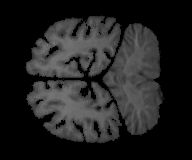

In [5]:
sys.path.append('../voxelmorph')
import src.networks as vm_networks
start_iter = 0
nf_enc = [16, 32, 32, 32]
nf_dec = [32, 32, 32, 32, 32, 16, 16]
# vm2 model
voxelmorph_model = vm_networks.cvpr2018_net(
    vol_size=(160, 192, 224),
    enc_nf=nf_enc, 
    dec_nf=nf_dec,
)

voxelmorph_model.summary()
import data_utils
sys.path.append('../voxelmorph')
import src.losses as vm_losses
# just train voxelmorph
voxelmorph_model.compile(
    #loss=['mean_squared_error', vm_losses.gradientLoss('l2')],
    loss=[vm_losses.NCC().loss, vm_losses.Grad('l2').loss],
    #loss_weights=[1.0, ,0.01],
    loss_weights=[1.0, 1.],#0.01],
    optimizer=Adam(0.0001)
)

#source_X = ds.X_atlas
source_X, _ = adni_loader._load_vol_and_seg(ds.files_labeled_train[0], load_seg=False, mask_vol=ds.params['masked'])
source_X = source_X[np.newaxis]
IPython.display.display(PIL.Image.fromarray((source_X[0, :, :, 64, 0]*255).astype(np.uint8)))



In [6]:

# copy weights from regular voxelmorph as initialization
for li, l in enumerate(voxelmorph_model.layers):
    print(l.name)
    if l.name == voxelmorph_model_old.layers[li].name:
        print(l.name)
        voxelmorph_model.layers[li].set_weights(voxelmorph_model_old.layers[li].get_weights())

input_1
input_1
input_2
input_2
concatenate_1
concatenate_1
conv3d_1
conv3d_1
leaky_re_lu_1
leaky_re_lu_1
conv3d_2
conv3d_2
leaky_re_lu_2
leaky_re_lu_2
conv3d_3
conv3d_3
leaky_re_lu_3
leaky_re_lu_3
conv3d_4
conv3d_4
leaky_re_lu_4
leaky_re_lu_4
conv3d_5
conv3d_5
leaky_re_lu_5
leaky_re_lu_5
up_sampling3d_1
up_sampling3d_1
concatenate_2
concatenate_2
conv3d_6
conv3d_6
leaky_re_lu_6
leaky_re_lu_6
up_sampling3d_2
up_sampling3d_2
concatenate_3
concatenate_3
conv3d_7
conv3d_7
leaky_re_lu_7
leaky_re_lu_7
up_sampling3d_3
up_sampling3d_3
concatenate_4
concatenate_4
conv3d_8
conv3d_8
leaky_re_lu_8
leaky_re_lu_8
conv3d_9
conv3d_9
leaky_re_lu_9
leaky_re_lu_9
up_sampling3d_4
up_sampling3d_4
concatenate_5
concatenate_5
conv3d_10
conv3d_10
leaky_re_lu_10
leaky_re_lu_10
conv3d_11
conv3d_11
leaky_re_lu_11
leaky_re_lu_11
flow
flow
spatial_transformer_1


In [ ]:
n_train_iters = 50000
vol_gen = ds.gen_vols_batch(['labeled_train', 'unlabeled_train'], batch_size=1, randomize=True)
print(ds.files_labeled_train + ds.files_unlabeled_train)
#vol_gen = data_utils.gen_batch(X_unlabeled, X_unlabeled, batch_size=1, randomize=True)
target_X, _ = next(vol_gen)
zeros_flow = np.zeros(target_X.shape[:-1] + (3,))

for bi in range(n_train_iters + 1):
    
    target_X, _ = next(vol_gen)
    
    # subject-to-atlas training
    vm_losses = voxelmorph_model.train_on_batch([target_X, source_X], [source_X, zeros_flow])
    #[source_X, target_X], [target_X, zeros_flow])
    print('Iter {}, loss {}'.format(bi, vm_losses))
    
    if bi > 0 and bi % 2000 == 0:
        voxelmorph_model.save('./experiments/voxelmorph/vm2_cc_AtoUMS_nd_100k_vm2ij_ftiter{}.h5'.format(start_iter + bi))

['atlas', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_263697.long.153_S_4077_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_223532.long.153_S_2109_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-1.5T-FS-5.3-Long_76615.long.021_S_0984_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_451346.long.009_S_0751_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_100329_NW33DK_FS_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_282668.long.002_S_4270_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_110314_JD99RH_FS_mri_talairach_orig.npz', '/data/ddm

Iter 0, loss [-0.05818331, -0.09308211, 0.0348988]
Iter 1, loss [-0.050301313, -0.08935191, 0.039050594]
Iter 2, loss [-0.07071841, -0.101206, 0.030487588]
Iter 3, loss [-0.09183802, -0.11358444, 0.02174642]
Iter 4, loss [-0.083317, -0.1019043, 0.018587306]
Iter 5, loss [-0.056581948, -0.089390144, 0.032808196]
Iter 6, loss [-0.092122994, -0.11414479, 0.022021791]
Iter 7, loss [-0.10455403, -0.12136755, 0.01681352]
Iter 8, loss [-0.09463798, -0.11093454, 0.016296556]
Iter 9, loss [-0.08198929, -0.100674294, 0.018685007]
Iter 10, loss [-0.09467329, -0.11576111, 0.021087822]
Iter 11, loss [-0.12049021, -0.14026627, 0.01977606]
Iter 12, loss [-0.10219734, -0.123732395, 0.021535054]
Iter 13, loss [-0.10797404, -0.13128772, 0.023313683]
Iter 14, loss [-0.103027984, -0.12799522, 0.024967235]
Iter 15, loss [-0.11368598, -0.13993223, 0.026246246]
Iter 16, loss [-0.108465195, -0.1351181, 0.026652902]
Iter 17, loss [-0.120730236, -0.15085594, 0.030125704]
Iter 18, loss [-0.11061436, -0.14249158,

In [ ]:
IPython.display.display(PIL.Image.fromarray(source_X[0, :, :, 112, :]))
IPython.display.display(PIL.Image.fromarray(target_X[0, :, :, 112, :]))
preds = voxelmorph_model.predict([source_X, target_X])
IPython.display.display(PIL.Image.fromarray(target_X[0, :, :, 112, :]))


In [ ]:
# # save a voxelmorph wrapper

# from keras.layers import Input, Lambda
# from keras.models import Model, load_model
# import sys
# sys.path.append('../voxelmorph/src')
# from dense_3D_spatial_transformer import Dense3DSpatialTransformer



# import os
# import tensorflow as tf
# import keras.backend as K
# gpu_ids = [2]
# # set gpu id and tf settings
# os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(g) for g in gpu_ids])
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# K.tensorflow_backend.set_session(tf.Session(config=config))



# voxelmorph_model = load_model(
#     #'/afs/csail.mit.edu/u/x/xamyzhao/voxelmorph/models/vm2_cc.h5',
#     './experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_iter100000.h5',#.format(start_iter),
#     custom_objects={'Dense3DSpatialTransformer': Dense3DSpatialTransformer},
#     compile=False,
# )

# vol_shape = (160, 224, 192, 1)
# input_src = Input(vol_shape)
# input_tgt = Input(vol_shape)

# warped, flow = voxelmorph_model([input_src, input_tgt])
# flow = Lambda(lambda x:tf.gather(x, [1, 0, 2], axis=-1))(flow)  # reverse rows, cols

# wrapper_model = Model(inputs=[input_src, input_tgt], outputs=[flow, warped], name='vm2_cc_wrapper')
# wrapper_model.summary()
# wrapper_model.save('./experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_iter100000_wrapper.h5')